# LSTM and GRU with cortical electrophys
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first three cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell
%load_ext tensorboard.notebook

In [3]:
# Download and unzip data (3.4 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare Data

### Import

In [4]:
from data.utils.fileio import load_joeyo_reaching
sess_names = ['indy_2016' + _ for _ in ['0921_01', '0927_04', '0927_06', '0930_02', '0930_05' '1005_06' '1006_02']]
sess_name = sess_names[0]
X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_name, x_chunk='spikerates')

### Prepare for TensorFlow
TODO: If we want to use LFP data (1 kHz) we need to downsample it or upsample behaviour (250 Hz)

Y has finger position (3-D), cursor position (2-D; direct projection of finger position), and the target position. We need only the cursor position, so we select only those channels from Y.

Both X and Y come in shape (channels, samples) as float64. We need them in (segments, samples, channels) as float32.

Finally, we create training and validation sets.

In [5]:
from sklearn.model_selection import train_test_split
SEQ_LENGTH = 100
P_TRAIN = 0.8
BATCH_SIZE = 5
behav_chans = ['CursorX', 'CursorY']

# Slice Y to only keep required behaviour data.
b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , behav_chans)
Y = Y[b_keep_y_chans, :]

# Segment X and Y into sequences of length seq_length
n_drop = X.shape[-1] % SEQ_LENGTH
X = X[:, :-n_drop].astype(np.float32).reshape((X.shape[0], -1, SEQ_LENGTH)).transpose((1, 2, 0))
Y = Y[:, :-n_drop].astype(np.float32).reshape((Y.shape[0], -1, SEQ_LENGTH)).transpose((1, 2, 0))
n_trials = X.shape[0]

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=P_TRAIN)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train = ds_train.shuffle(int(n_trials * P_TRAIN) + 1).batch(BATCH_SIZE, drop_remainder=True)  # , drop_remainder=True?
ds_valid = ds_valid.batch(BATCH_SIZE)

## Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)
[This blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) from mid-2015 is still one of the best explanations of LSTMs around. The short of it is that each LSTM cell has three functions or 'gates' that decide (on each step) how much of the state (forget gate) gets combined with how much of the input (update gate) to make the new state, and how much of the input gets combined with the state to make the output (output gate).

GRUs are similar in concept but use only two gates: an update gate and a reset gate. [See here](https://arxiv.org/pdf/1412.3555v1.pdf).

As such, LSTMs are slightly more sophisticated and theoretically could model more of your model space, but in practice GRUs usually do just as well and are more efficient computationally. We will quickly try each version.

### Implementation Details
This will probably change, but the unification of LSTM APIs in TensorFlow 2.0 means that there are some constraints on how an LSTM can be parameterized and still run on the GPU.

1. activation == 'tanh'
2. recurrent_activation == 'sigmoid'
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. No use of masking.

In [9]:
N_RNN_UNITS = 2
inputs = tf.keras.layers.Input(shape=(SEQ_LENGTH, X.shape[-1]))
outputs = tf.keras.layers.LSTM(N_RNN_UNITS, return_sequences=True)(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

W0604 12:28:21.643764  3564 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x0000023F77BE9D30>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 257)]        0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 100, 2)            2080      
Total params: 2,080
Trainable params: 2,080
Non-trainable params: 0
_________________________________________________________________


In [10]:
EPOCHS = 100
history = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

Epoch 1/100
144/144 [==============================] - ETA: 1:16 - loss: 2901.98 - ETA: 41s - loss: 3478.2501 - ETA: 8s - loss: 2782.293 - ETA: 4s - loss: 2647.98 - ETA: 3s - loss: 2700.17 - ETA: 2s - loss: 2645.44 - ETA: 2s - loss: 2704.97 - ETA: 1s - loss: 2738.52 - ETA: 1s - loss: 2723.52 - ETA: 1s - loss: 2747.66 - ETA: 0s - loss: 2717.99 - ETA: 0s - loss: 2708.18 - ETA: 0s - loss: 2714.61 - ETA: 0s - loss: 2685.59 - ETA: 0s - loss: 2671.66 - ETA: 0s - loss: 2641.66 - ETA: 0s - loss: 2652.62 - ETA: 0s - loss: 2672.18 - ETA: 0s - loss: 2667.75 - 2s 12ms/step - loss: 2668.6155 - val_loss: 2665.2590
Epoch 2/100
144/144 [==============================] - ETA: 4s - loss: 2832.97 - ETA: 1s - loss: 2804.80 - ETA: 1s - loss: 2678.33 - ETA: 0s - loss: 2666.62 - ETA: 0s - loss: 2653.25 - ETA: 0s - loss: 2697.87 - ETA: 0s - loss: 2732.28 - ETA: 0s - loss: 2717.82 - ETA: 0s - loss: 2750.39 - ETA: 0s - loss: 2716.76 - ETA: 0s - loss: 2705.41 - ETA: 0s - loss: 2710.91 - ETA: 0s - loss: 2703.58 -

144/144 [==============================] - ETA: 5s - loss: 2833.64 - ETA: 1s - loss: 2792.27 - ETA: 1s - loss: 2666.98 - ETA: 0s - loss: 2676.30 - ETA: 0s - loss: 2623.72 - ETA: 0s - loss: 2684.85 - ETA: 0s - loss: 2720.53 - ETA: 0s - loss: 2706.21 - ETA: 0s - loss: 2731.18 - ETA: 0s - loss: 2701.67 - ETA: 0s - loss: 2692.14 - ETA: 0s - loss: 2699.07 - ETA: 0s - loss: 2670.55 - ETA: 0s - loss: 2657.31 - ETA: 0s - loss: 2627.00 - ETA: 0s - loss: 2637.82 - ETA: 0s - loss: 2657.61 - ETA: 0s - loss: 2653.26 - 1s 8ms/step - loss: 2654.2683 - val_loss: 2659.3377
Epoch 16/100
144/144 [==============================] - ETA: 5s - loss: 2833.81 - ETA: 1s - loss: 2792.33 - ETA: 1s - loss: 2666.95 - ETA: 0s - loss: 2653.81 - ETA: 0s - loss: 2623.23 - ETA: 0s - loss: 2684.50 - ETA: 0s - loss: 2720.02 - ETA: 0s - loss: 2705.82 - ETA: 0s - loss: 2730.86 - ETA: 0s - loss: 2701.38 - ETA: 0s - loss: 2691.89 - ETA: 0s - loss: 2698.81 - ETA: 0s - loss: 2670.23 - ETA: 0s - loss: 2657.00 - ETA: 0s - loss: 2

144/144 [==============================] - ETA: 5s - loss: 2830.11 - ETA: 1s - loss: 2788.55 - ETA: 1s - loss: 2663.29 - ETA: 0s - loss: 2651.28 - ETA: 0s - loss: 2636.78 - ETA: 0s - loss: 2697.11 - ETA: 0s - loss: 2688.90 - ETA: 0s - loss: 2682.04 - ETA: 0s - loss: 2724.47 - ETA: 0s - loss: 2698.48 - ETA: 0s - loss: 2688.76 - ETA: 0s - loss: 2695.71 - ETA: 0s - loss: 2685.59 - ETA: 0s - loss: 2652.49 - ETA: 0s - loss: 2623.10 - ETA: 0s - loss: 2633.60 - ETA: 0s - loss: 2660.64 - ETA: 0s - loss: 2662.63 - 1s 8ms/step - loss: 2650.5790 - val_loss: 2658.3517
Epoch 30/100
144/144 [==============================] - ETA: 5s - loss: 2830.05 - ETA: 1s - loss: 2742.96 - ETA: 1s - loss: 2617.12 - ETA: 0s - loss: 2673.46 - ETA: 0s - loss: 2619.88 - ETA: 0s - loss: 2680.96 - ETA: 0s - loss: 2716.33 - ETA: 0s - loss: 2702.36 - ETA: 0s - loss: 2727.48 - ETA: 0s - loss: 2698.09 - ETA: 0s - loss: 2688.37 - ETA: 0s - loss: 2695.33 - ETA: 0s - loss: 2666.48 - ETA: 0s - loss: 2653.24 - ETA: 0s - loss: 2

144/144 [==============================] - ETA: 5s - loss: 2826.88 - ETA: 1s - loss: 2785.10 - ETA: 1s - loss: 2659.91 - ETA: 0s - loss: 2647.08 - ETA: 0s - loss: 2632.14 - ETA: 0s - loss: 2692.94 - ETA: 0s - loss: 2685.15 - ETA: 0s - loss: 2678.32 - ETA: 0s - loss: 2720.80 - ETA: 0s - loss: 2692.50 - ETA: 0s - loss: 2690.99 - ETA: 0s - loss: 2698.90 - ETA: 0s - loss: 2668.44 - ETA: 0s - loss: 2655.83 - ETA: 0s - loss: 2619.57 - ETA: 0s - loss: 2630.35 - ETA: 0s - loss: 2649.92 - ETA: 0s - loss: 2645.63 - 1s 8ms/step - loss: 2646.6154 - val_loss: 2657.4688
Epoch 44/100
144/144 [==============================] - ETA: 5s - loss: 2827.18 - ETA: 1s - loss: 2784.86 - ETA: 1s - loss: 2659.58 - ETA: 0s - loss: 2669.07 - ETA: 0s - loss: 2615.53 - ETA: 0s - loss: 2696.03 - ETA: 0s - loss: 2687.48 - ETA: 0s - loss: 2706.48 - ETA: 0s - loss: 2711.47 - ETA: 0s - loss: 2694.54 - ETA: 0s - loss: 2683.40 - ETA: 0s - loss: 2683.06 - ETA: 0s - loss: 2696.63 - ETA: 0s - loss: 2647.52 - ETA: 0s - loss: 2

144/144 [==============================] - ETA: 5s - loss: 2825.85 - ETA: 1s - loss: 2784.28 - ETA: 1s - loss: 2658.66 - ETA: 0s - loss: 2645.75 - ETA: 0s - loss: 2630.64 - ETA: 0s - loss: 2691.29 - ETA: 0s - loss: 2711.43 - ETA: 0s - loss: 2697.50 - ETA: 0s - loss: 2722.56 - ETA: 0s - loss: 2693.27 - ETA: 0s - loss: 2685.49 - ETA: 0s - loss: 2690.77 - ETA: 0s - loss: 2680.10 - ETA: 0s - loss: 2646.88 - ETA: 0s - loss: 2617.50 - ETA: 0s - loss: 2627.83 - ETA: 0s - loss: 2654.91 - ETA: 0s - loss: 2653.41 - 1s 8ms/step - loss: 2644.6950 - val_loss: 2656.0950
Epoch 58/100
144/144 [==============================] - ETA: 5s - loss: 2825.91 - ETA: 1s - loss: 2738.49 - ETA: 0s - loss: 2660.25 - ETA: 0s - loss: 2679.48 - ETA: 0s - loss: 2619.11 - ETA: 0s - loss: 2695.03 - ETA: 0s - loss: 2683.53 - ETA: 0s - loss: 2710.86 - ETA: 0s - loss: 2730.64 - ETA: 0s - loss: 2696.89 - ETA: 0s - loss: 2685.41 - ETA: 0s - loss: 2690.64 - ETA: 0s - loss: 2679.99 - ETA: 0s - loss: 2646.78 - ETA: 0s - loss: 2

144/144 [==============================] - ETA: 5s - loss: 2825.46 - ETA: 1s - loss: 2782.94 - ETA: 1s - loss: 2657.52 - ETA: 0s - loss: 2644.76 - ETA: 0s - loss: 2629.92 - ETA: 0s - loss: 2690.64 - ETA: 0s - loss: 2710.73 - ETA: 0s - loss: 2696.67 - ETA: 0s - loss: 2721.75 - ETA: 0s - loss: 2692.41 - ETA: 0s - loss: 2684.59 - ETA: 0s - loss: 2689.91 - ETA: 0s - loss: 2679.28 - ETA: 0s - loss: 2646.12 - ETA: 0s - loss: 2616.75 - ETA: 0s - loss: 2627.04 - ETA: 0s - loss: 2645.17 - ETA: 0s - loss: 2655.98 - 1s 8ms/step - loss: 2643.9914 - val_loss: 2655.5895
Epoch 72/100
144/144 [==============================] - ETA: 5s - loss: 2825.55 - ETA: 1s - loss: 2782.50 - ETA: 1s - loss: 2611.07 - ETA: 0s - loss: 2667.07 - ETA: 0s - loss: 2613.65 - ETA: 0s - loss: 2674.94 - ETA: 0s - loss: 2710.67 - ETA: 0s - loss: 2696.57 - ETA: 0s - loss: 2721.66 - ETA: 0s - loss: 2692.39 - ETA: 0s - loss: 2682.63 - ETA: 0s - loss: 2689.39 - ETA: 0s - loss: 2660.53 - ETA: 0s - loss: 2647.31 - ETA: 0s - loss: 2

144/144 [==============================] - ETA: 5s - loss: 2825.48 - ETA: 1s - loss: 2736.46 - ETA: 1s - loss: 2610.61 - ETA: 0s - loss: 2666.78 - ETA: 0s - loss: 2613.41 - ETA: 0s - loss: 2694.13 - ETA: 0s - loss: 2682.69 - ETA: 0s - loss: 2709.90 - ETA: 0s - loss: 2729.62 - ETA: 0s - loss: 2695.82 - ETA: 0s - loss: 2684.20 - ETA: 0s - loss: 2689.51 - ETA: 0s - loss: 2678.90 - ETA: 0s - loss: 2645.73 - ETA: 0s - loss: 2616.36 - ETA: 0s - loss: 2626.61 - ETA: 0s - loss: 2653.73 - ETA: 0s - loss: 2652.33 - 1s 8ms/step - loss: 2643.5619 - val_loss: 2655.7294
Epoch 86/100
144/144 [==============================] - ETA: 5s - loss: 2825.37 - ETA: 1s - loss: 2736.63 - ETA: 1s - loss: 2610.54 - ETA: 0s - loss: 2678.19 - ETA: 0s - loss: 2618.03 - ETA: 0s - loss: 2694.10 - ETA: 0s - loss: 2682.66 - ETA: 0s - loss: 2709.85 - ETA: 0s - loss: 2729.54 - ETA: 0s - loss: 2685.15 - ETA: 0s - loss: 2667.08 - ETA: 0s - loss: 2684.53 - ETA: 0s - loss: 2693.94 - ETA: 0s - loss: 2644.90 - ETA: 0s - loss: 2

144/144 [==============================] - ETA: 5s - loss: 2825.36 - ETA: 1s - loss: 2781.86 - ETA: 1s - loss: 2656.74 - ETA: 0s - loss: 2644.20 - ETA: 0s - loss: 2613.25 - ETA: 0s - loss: 2674.81 - ETA: 0s - loss: 2710.33 - ETA: 0s - loss: 2696.14 - ETA: 0s - loss: 2729.31 - ETA: 0s - loss: 2695.48 - ETA: 0s - loss: 2666.76 - ETA: 0s - loss: 2684.23 - ETA: 0s - loss: 2681.98 - ETA: 0s - loss: 2644.63 - ETA: 0s - loss: 2619.85 - ETA: 0s - loss: 2625.78 - ETA: 0s - loss: 2649.69 - ETA: 0s - loss: 2661.11 - 1s 8ms/step - loss: 2643.3225 - val_loss: 2655.9843
Epoch 100/100
144/144 [==============================] - ETA: 5s - loss: 2825.41 - ETA: 1s - loss: 2781.81 - ETA: 1s - loss: 2610.30 - ETA: 0s - loss: 2666.28 - ETA: 0s - loss: 2617.84 - ETA: 0s - loss: 2693.81 - ETA: 0s - loss: 2682.36 - ETA: 0s - loss: 2709.56 - ETA: 0s - loss: 2729.27 - ETA: 0s - loss: 2695.62 - ETA: 0s - loss: 2683.95 - ETA: 0s - loss: 2689.31 - ETA: 0s - loss: 2678.71 - ETA: 0s - loss: 2645.55 - ETA: 0s - loss: 

W0604 12:31:45.792455  3564 legend.py:1289] No handles with labels found to put in legend.


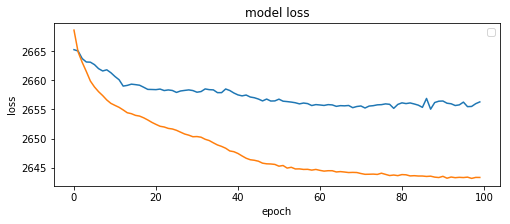

In [12]:
fig = plt.figure(figsize=(8, 3), facecolor='white')
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()